# Collated membrane blebbing figures

This notebook is designed to generate figures for comparison of membrane blebbing events with consistent colour/intensity scaling. 

## Usage
### Input data setup
* Make a new folder with the experiment (or comparison) title as its name.
* Copy (dated) folders output from the "blebbing analysis" ImageJ tool into the experiment folder
* If desired, rename these dated folders according to the condition they represent. To control the ordering of the images, it's advisable to name folders like "A) condition 1". 

### Plotting parameter setup
* In the <b>Setup</b> section below, change the `experiment_folder` variable to the path to the folder created above. <i>Be careful to use \\ to separate path elements!</i>
* Control the naming of conditions: by default, figure sub-titles area taken from the path of the <i>original data used to generate the analysis</i>. There are two options to override this behaviour: 
    * If the `condition_names` variable in the <b>Setup</b> section is changed to a list of conditions (e.g. `condition_names = ["control", "condition 1", "condition 2"]`), these names will be applied in the figures. Be aware, though, that there's no explicit control of ordering in this case, so caution is advised. 
    * If condition_names is left as None and `use_subfolder_as_condition` is set to True in the <b>Setup</b> section, then the <i>output</i> subfolders will be used to name conditions - see <b>Input data setup</b> above. 
* Scale bar appearance can be modified by changing the desired length in microns, the colour and the position (normalised to the axis) by changing `scale_bar_size_um`, `scale_bar_color`, and `scale_bar_position`, respectively, in the <b>Setup</b> section below. Note that single letter colour codes can be found [here](https://matplotlib.org/2.0.2/api/colors_api.html). 
* To make merged kymographs appear brighter, the `contrast_enhancement` variable's value may be increased - recommended value is about 0.35. 
* To control the time points displayed in the montage of curvatures overlaid on membrane images, a list of times (in the same units as the original data) should be provided using the `chosen_timepoints` variable. Note that if the chosen time points fall before the start or after the end of the data for a given condition, those time points will not be rendered. If this condition is met but the chosen time point falls between existing time points in the data, the closest time point to the target will be rendered - for example, for data collected at 5 second intervals, if `chosen_timepoints` includes 11, the frame from 10 seconds will be rendered instead. 


### Font setup
* In the <b>Font setup</b> section below, change axis label, tick label, title and subtitle font size to taste. 
* Note that, within reason, wrapping should be automatically taken care of to prevent overlapping titles


### Generating figures
* After setting up to taste, go to Cell -> Run All
* A montage of kymographs and derived plots will appear about halfway down the page; a montage of curvatures overlaid on membrane images will be displayed at the bottom of the page. 


## Setup

In [1]:
# experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\Experiment 1";
# experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\2019-01-22 14-30-44 output\\looped analysis"
# experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\2019-01-29 16-16-23 output\\Varying intensity thickness parameter"
#experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\2019-01-29 17-10-59 output\\Varying curvature length parameter"
# experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1"
# experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\bg std test\\2019-02-06 16-11-38 output\\looped analysis"
experiment_folder = "C:\\Users\\dougk\\Desktop\\output\\Experiment 2\\Experiment 2"
condition_names = None;
#condition_names = ["control", "condition 1", "condition 2"]
annotation_arrows = None;
#annotation_arrows = [(2, (100/360, 0.8)), (2, (200/360, 0.8)), (2, (300/360, 0.8))];
use_subfolder_as_condition = True;
abs_bleb_gradient_threshold = 10;
curvature_threshold = 0.005;
scale_bar_size_um = 1.0;
scale_bar_position = (0.75, 0.9) # in normalised axis coordinates
scale_bar_color = 'w';
contrast_enhancement = 0.35;
base_chosen_timepoints = [0, 120, 240, 354];
make_colorscale_symmetrical = True;
keep_time_and_length_scales_consistent = True;
normalise_intensity_to_std = True;


## Font setup

In [2]:
axis_label_size = 12
tick_label_size = 12
title_size = 28
subtitle_size = 14

## Nuts and bolts - please do not change!

In [3]:
import os
import plotting
import matplotlib.pyplot as plt
import warnings
plotting.set_font_sizes(title_size, subtitle_size, axis_label_size, tick_label_size);

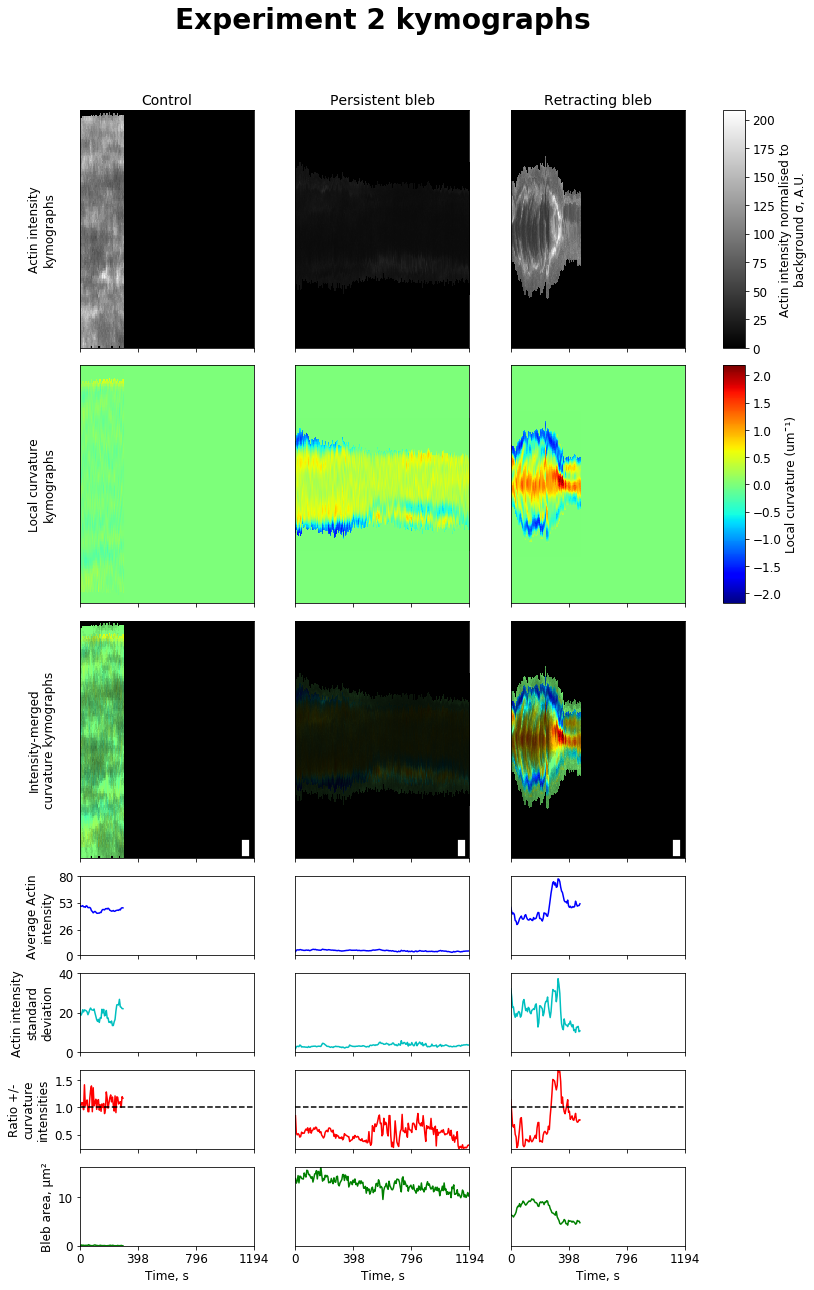

In [6]:
# load and plot kymographs
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    actin_kyms, curvature_kyms, paramses, column_titles, areas = plotting.load_kymograph_data(experiment_folder, 
                                                                        condition_names=condition_names, 
                                                                        use_subfolder_as_condition=use_subfolder_as_condition, 
                                                                        normalise_intensity_to_std=normalise_intensity_to_std);

experiment_title = os.path.basename(experiment_folder);
space_lims, time_lims, intensity_lims, curv_lims = plotting.get_normalisation_limits(paramses, 
                                                                            actin_kyms, 
                                                                            curvature_kyms, 
                                                                            make_colorscale_symmetrical)
fig, axs = plt.subplots(ncols=len(actin_kyms), 
                        nrows=7, 
                        sharex='col',
                        figsize=(3.5*len(actin_kyms),18), 
                        gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]});


actin_im, curv_im = plotting.plot_kymographs(paramses, 
                                             actin_kyms, 
                                             curvature_kyms, 
                                             axs, 
                                             intensity_lims, 
                                             curv_lims, 
                                             contrast_enhancement=contrast_enhancement);

average_nonzero_intensities, std_nonzero_intensities, intensity_ratios = plotting.plot_timeseries(paramses, 
                                                                                axs, 
                                                                                actin_kyms, 
                                                                                curvature_kyms, 
                                                                                areas, 
                                                                                curvature_threshold=curvature_threshold);   
       
# plotting.add_scalebar(paramses[idx], axs[2][idx], fig, color='w', scale_bar_size_um=1, vertical_scale_bar=True)

# handle presentation
plt.tight_layout()
fig.subplots_adjust(top=0.90, right=0.9, left=0.1);
plotting.adjust_kymograph_display(fig, 
                                axs, 
                                paramses, 
                                actin_im, 
                                curv_im, 
                                make_colorscale_symmetrical, 
                                column_titles, 
                                normalise_intensity_to_std=normalise_intensity_to_std);

plotting.adjust_time_series_plot_display(fig, 
                                       axs, 
                                       paramses, 
                                       average_nonzero_intensities, 
                                       std_nonzero_intensities, 
                                       intensity_ratios, 
                                       areas);

if keep_time_and_length_scales_consistent:
    plotting.do_space_time_normalisation(axs, paramses, space_lims, time_lims, make_colorscale_symmetrical);

for idx, ax in enumerate(axs[2]):
    plotting.add_scalebar(paramses[idx], 
                          ax, 
                          fig, 
                          color='w', 
                          scale_bar_size_um=1, 
                          vertical_scale_bar=True, 
                          prenormalised=keep_time_and_length_scales_consistent);

fig.suptitle(experiment_title + " kymographs");

plotting.add_arrow_annotations(axs, annotation_arrows);
        
plt.show();

C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


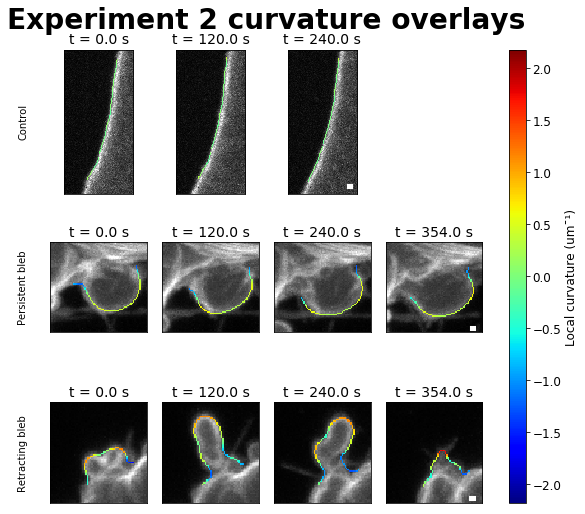

In [7]:
experiment_title = os.path.basename(experiment_folder);
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims, raw_curvatures, paramses, row_titles = plotting.load_data_for_overlay_montage(experiment_folder, 
                                                                          condition_names, 
                                                                          use_subfolder_as_condition)
fig, axs = plt.subplots(ncols=len(base_chosen_timepoints), 
                        nrows=len(ims), 
                        figsize=(2.5*len(ims),2.5*len(ims)));
   
curv_lims = plotting.get_overlay_normalisation_limits(paramses, ims, raw_curvatures, make_colorscale_symmetrical=make_colorscale_symmetrical);

plotting.plot_overlay_images(paramses, 
                             fig, 
                             axs, 
                             ims, 
                             raw_curvatures, 
                             curv_lims, 
                             base_chosen_timepoints, 
                             scale_bar_color, 
                             scale_bar_size_um);
        
plotting.adjust_overlay_images_display(fig, axs, paramses, curv_lims, experiment_title, row_titles);